In [2]:
import h5py 
import json
import numpy as np
import matplotlib.pyplot as plt
import utils

# load data from hdf5 files
datasets = ["beatles","rw","rwc_pop","queen"]
source_separation = ["none","vocals","drums","both"]
results = {}
for ii in range(4):
    dataset_results = {}
    for jj in range(4):
        with h5py.File(f"../results/majmin_rp_25_50/{source_separation[jj]}.hdf5", 'r') as file:
            # load parameters
            params = json.loads(file['/parameters'][()])
            # print(params)
            # load majmin scores
            scores = {}
            for track_id in file[f"/{datasets[ii]}"]:
                track_data = file[f"/{datasets[ii]}/{track_id}"]
                # harmonic mean, seg_score
                majmin_score,seg_score = track_data.attrs.get("majmin"),track_data.attrs.get("seg")
                f_score = (2 * majmin_score * seg_score) / (majmin_score + seg_score)
                scores[track_id] = (f_score,majmin_score,seg_score)
        dataset_results[source_separation[jj]] = scores
    results[datasets[ii]] = dataset_results


x = [(k,v) for k,v in results["queen"]["none"].items() if v[0]<0.5]
print(x)

[('1', (0.13629629629629628, 0.08, 0.46)), ('15', (0.24359999999999998, 0.21, 0.29))]


RW : "0213","0214","0305" </br>
RWC : "RM-P002","RM-P016","RM-P025","RM-P028","RM-P030",RM-P031","RM-P080","RM-P092" </br>
beatles : "0103-Anna Go to Him","0105","0505","0808","0810","10102","10105","10106","10114","10212","1208" </br>
queen : "1" , "15" "bohemian rhapsody", "Seven days of rhye"

Output(outputs=({'name': 'stdout', 'text': 'Loaded result file, select track_id\n', 'output_type': 'stream'},)…

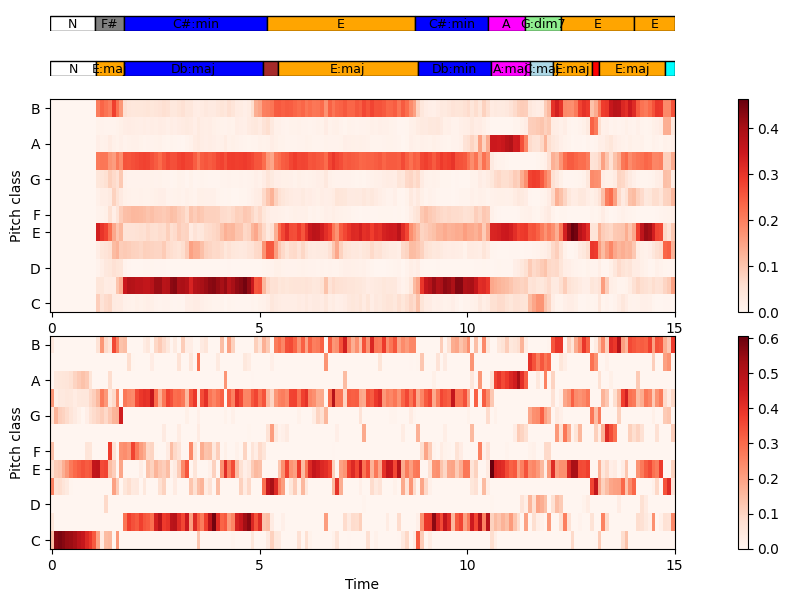

In [ ]:
import dataloader
%matplotlib inline
gui = dataloader.DatasetGUI("/home/max/ET-TI/Masterarbeit/chord-recognition");


ValueError: X must have 2 or fewer dimensions

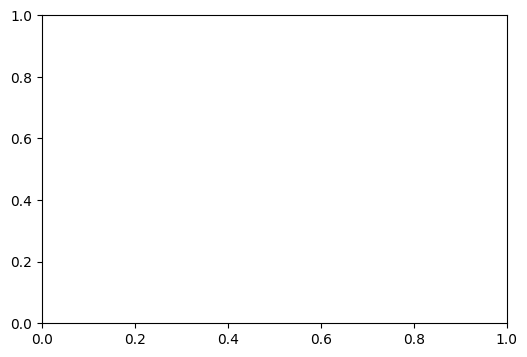

In [4]:

# violin plots
f_score = []
for source_sep in source_separation:
    temp = []
    for name in datasets:
        for track_id in results[name][source_sep]:  
            temp.append(100 * results[name][source_sep][track_id])
    f_score.append(temp)


fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.violinplot(f_score,showmeans=True, showmedians=False,
        showextrema=False)
xlabels = source_separation
ax1.set_yticks(np.arange(40,110,10))
ax1.set_ylim(40,100)
ax1.set_ylabel("f-score in %")
ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
ax1.set_xlim(0.25, len(xlabels) + 0.75);
ax1.grid("on")

## paired T-Test ##
source_sep = "drums"
delta = []
for dataset_name in datasets:
    for track_id in results[dataset_name]["none"]:
        delta.append(results[dataset_name][source_sep][track_id] - results[dataset_name]["none"][track_id] )
N = len(delta)
delta = np.array(delta)
delta_mu = np.mean(delta)
delta_std = np.std(delta,ddof=1) / np.sqrt(N)
t_obs = delta_mu/(delta_std)
print(f"t_obs={t_obs}")

Compare RP prefilter with median prefilter result

In [ ]:
median_filepath = "../results/majmin_median_11/none.hdf5"
rp_filepath = "../results/majmin_rp_25_50/none.hdf5"
f_scores_rp = []
f_scores_median = []
for dset_name in ["beatles","rwc_pop","rw","queen"]:
    f_scores_median.extend(utils.load_f_scores(median_filepath,dset_name))
    f_scores_rp.extend(utils.load_f_scores(rp_filepath,dset_name))
    

print(f"median: mean={np.mean(f_scores_median):.2f} +/- {np.std(f_scores_median):.2f}")
print(f"rp: mean={np.mean(f_scores_rp):.2f} +/- {np.std(f_scores_rp):.2f}")

N = len(f_scores_median)
median_std = np.std(f_scores_median,ddof=1)
rp_std = np.std(f_scores_rp,ddof=1)
delta_mu = np.mean(f_scores_rp)-np.mean(f_scores_median)
delta_std = np.sqrt(median_std**2 + rp_std**2)
t_obs =delta_mu/(delta_std/np.sqrt(N))
print(f"t_obs={t_obs}")

median: mean=0.71 +/- 0.15
rp: mean=0.73 +/- 0.16
t_obs=1.8366506159475064


In [ ]:

datasets = ["beatles","rwc_pop","rw","queen"]

for dset_name in datasets:
    f_scores_median = utils.load_f_scores(f"../results/majmin_median_11/none.hdf5",dset_name)
    print(dset_name)
    print(f"median: mean={np.mean(f_scores_median):.2f} +/- {np.std(f_scores_median):.2f}")


beatles
median: mean=0.71 +/- 0.17
rwc_pop
median: mean=0.72 +/- 0.13
rw
median: mean=0.74 +/- 0.14
queen
median: mean=0.64 +/- 0.18


In [ ]:
import mir_eval
import utils
# example of evaluation schemes
x = mir_eval.chord.quality_to_bitmap("min7")
est_intervals = np.array([[0,1],[1,3]])
est_labels = ["A:min","A:min7"]
ref_intervals = np.array([[0,1],[1,3]])
ref_labels = ["A:sus2","A:min7"]
score,seg = utils.evaluateTranscription(est_intervals,est_labels,ref_intervals,ref_labels,scheme="sevenths")
print(f"majmin={score} , seg={seg}")

majmin=1.0 , seg=1.0
